In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/us-patent-phrase-to-phrase-matching/sample_submission.csv
/kaggle/input/us-patent-phrase-to-phrase-matching/train.csv
/kaggle/input/us-patent-phrase-to-phrase-matching/test.csv
/kaggle/input/cpc-codes/titles.csv


# Credits:
this notebook is based on the notbook ["Getting started with NLP for absolute beginners"](https://www.kaggle.com/code/jhoward/getting-started-with-nlp-for-absolute-beginners) by @Jeremy Howard

# EDA

In [2]:
train = pd.read_csv("/kaggle/input/us-patent-phrase-to-phrase-matching/train.csv")
print(train.shape)
train.head()

(36473, 5)


,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


In [3]:
train.describe(include='object')

,id,anchor,target,context
count,36473,36473,36473,36473
unique,36473,733,29340,106
top,37d61fd2272659b1,component composite coating,composition,H01
freq,1,152,24,2186


In [4]:
# The maximum width in characters of a column in the repr of a pandas data structure
pd.set_option('display.max_colwidth', None)

In [5]:
train['score'].unique()

array([0.5 , 0.75, 0.25, 0.  , 1.  ])

In [6]:
train.groupby('score').count()

,id,anchor,target,context
score,,,,
0.00,7471,7471,7471,7471
0.25,11519,11519,11519,11519
0.50,12300,12300,12300,12300
0.75,4029,4029,4029,4029
1.00,1154,1154,1154,1154


## Score meanings according to [Data Description](https://www.kaggle.com/competitions/us-patent-phrase-to-phrase-matching/data?select=train.csv)

The scores are in the 0-1 range with increments of 0.25 with the following meanings:

    1.0 - Very close match. This is typically an exact match except possibly for differences in conjugation, quantity (e.g. singular vs. plural), and addition or removal of stopwords (e.g. “the”, “and”, “or”).
    0.75 - Close synonym, e.g. “mobile phone” vs. “cellphone”. This also includes abbreviations, e.g. "TCP" -> "transmission control protocol".
    0.5 - Synonyms which don’t have the same meaning (same function, same properties). This includes broad-narrow (hyponym) and narrow-broad (hypernym) matches.
    0.25 - Somewhat related, e.g. the two phrases are in the same high level domain but are not synonyms. This also includes antonyms.
    0.0 - Unrelated.


Obviously, there are more phrases that are "Synonyms which don’t have the same meaning" than other categories.

In [7]:
train.groupby('score').nunique()

,id,anchor,target,context
score,,,,
0.00,7471,725,6618,104
0.25,11519,727,9286,106
0.50,12300,729,10681,106
0.75,4029,682,3667,104
1.00,1154,470,973,100


There are more unique elements in "target" and it's logic as one type of anchor or context can have different targets.

I create a small dataset for future visualisation purposes

In [8]:
train_small = train.iloc[:5]
train_small

,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


# Test Corpus

In [9]:
test = pd.read_csv("/kaggle/input/us-patent-phrase-to-phrase-matching/test.csv")

In [10]:
test.shape

(36, 4)

## Imports

In [11]:
import tensorflow as tf
import tensorflow_hub as hub
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
def cosine(u, v):
    """
    cosine similarity definition
    """
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

# USE

The Universal Sentence Encoder (USE) is a simple way to get first results.

In [13]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" 
model = hub.load(module_url)
sentences = train["anchor"].values.tolist()
queries = train["target"].values.tolist()

2022-06-07 23:46:06.294916: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-06-07 23:46:08.917190: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [14]:
model([sentences[0]])

<tf.Tensor: shape=(1, 512), dtype=float32, numpy=
array([[-1.98577363e-02, -1.21083017e-02,  7.35915452e-02,
        -1.75086278e-02, -7.56860152e-02,  4.43453342e-02,
        -1.89508486e-03, -3.86596359e-02, -2.21199798e-03,
        -3.23769040e-02, -1.59707703e-02,  3.50723835e-03,
         1.00384150e-02,  4.36185710e-02,  4.43858840e-02,
         2.15943921e-02, -1.73553936e-02, -9.47407726e-03,
        -5.10946997e-02, -5.29839173e-02,  2.18188353e-02,
         1.34214191e-02,  6.18544444e-02, -2.17084177e-02,
        -7.67348558e-02,  1.37703819e-02,  8.58319625e-02,
        -2.24876944e-02,  4.23451476e-02,  5.16811535e-02,
        -1.26123745e-02,  1.94951631e-02, -7.78470337e-02,
         1.40407663e-02, -3.61797512e-02, -6.05124002e-03,
         3.45869288e-02,  1.29948473e-02,  3.63643398e-03,
         3.98442242e-03, -4.11943644e-02,  3.91497836e-02,
         1.08268978e-02, -2.92333793e-02, -8.82212222e-02,
        -1.99024100e-02, -9.52992588e-03,  3.91328335e-02,
      

## Cosine similarity

In [15]:
cosine(model([sentences[0]])[0], model([queries[0]])[0])

0.58807564

In [16]:
train["score_f"] = [cosine(model([s])[0], model([q])[0]) for s, q in zip(sentences, queries)]
np.corrcoef(train["score_f"], train["score"])

array([[1.        , 0.50924276],
       [0.50924276, 1.        ]])

In [17]:
exampq = train_small["target"].values.tolist()
exampq

['abatement of pollution',
 'act of abating',
 'active catalyst',
 'eliminating process',
 'forest region']

In [18]:
def plot_similarity(labels, features, rotation):
    """
    heat map for phrases
    """
    corr = np.inner(features, features)
    sns.set(font_scale=1.2)
    g = sns.heatmap(
    corr,
    xticklabels=labels,
    yticklabels=labels,
    vmin=0,
    vmax=1,
    cmap="YlOrRd")
    g.set_xticklabels(labels, rotation=rotation)
    g.set_title("Semantic Textual Similarity")


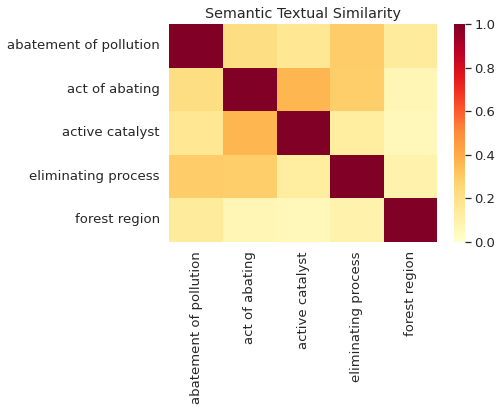

In [19]:
plot_similarity(exampq, model(exampq), 90)

We see here that even if theses phrases belong to the same encore, they are not all equally correllated between themselves

In [20]:
train.head()

,id,anchor,target,context,score,score_f
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,0.588076
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,0.294865
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,0.274901
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,0.401130
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,0.202257


In [21]:
train_use = train.copy()
train_use.head()

,id,anchor,target,context,score,score_f
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,0.588076
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,0.294865
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,0.274901
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,0.401130
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,0.202257


In [22]:
train = train.drop(columns=['score_f'])
train.head()

,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


# External Context

In [23]:
# ajouter le contexte https://www.cooperativepatentclassification.org/Archive
# extraire le contexte du fichier xml

In [24]:
titles = pd.read_csv("../input/cpc-codes/titles.csv")
print(titles.shape)
titles.head()

(260476, 7)


,code,title,section,class,subclass,group,main_group
0,A,HUMAN NECESSITIES,A,NaN,NaN,NaN,NaN
1,A01,AGRICULTURE; FORESTRY; ANIMAL HUSBANDRY; HUNTING; TRAPPING; FISHING,A,1.0,NaN,NaN,NaN
2,A01B,"SOIL WORKING IN AGRICULTURE OR FORESTRY; PARTS, DETAILS, OR ACCESSORIES OF AGRICULTURAL MACHINES OR IMPLEMENTS, IN GENERAL (making or covering furrows or holes for sowing, planting, or manuring A01C5/00; soil working for engineering purposes E01, E02, E21; {measuring areas for agricultural purposes G01B})",A,1.0,B,NaN,NaN
3,A01B1/00,Hand tools (edge trimmers for lawns A01G3/06 {; machines for working soil A01B35/00; making hand tools B21D}),A,1.0,B,1.0,0.0
4,A01B1/02,Spades; Shovels {(hand-operated dredgers E02F3/02)},A,1.0,B,1.0,2.0


In [25]:
titles

,code,title,section,class,subclass,group,main_group
0,A,HUMAN NECESSITIES,A,NaN,NaN,NaN,NaN
1,A01,AGRICULTURE; FORESTRY; ANIMAL HUSBANDRY; HUNTING; TRAPPING; FISHING,A,1.0,NaN,NaN,NaN
2,A01B,"SOIL WORKING IN AGRICULTURE OR FORESTRY; PARTS, DETAILS, OR ACCESSORIES OF AGRICULTURAL MACHINES OR IMPLEMENTS, IN GENERAL (making or covering furrows or holes for sowing, planting, or manuring A01C5/00; soil working for engineering purposes E01, E02, E21; {measuring areas for agricultural purposes G01B})",A,1.0,B,NaN,NaN
3,A01B1/00,Hand tools (edge trimmers for lawns A01G3/06 {; machines for working soil A01B35/00; making hand tools B21D}),A,1.0,B,1.0,0.0
4,A01B1/02,Spades; Shovels {(hand-operated dredgers E02F3/02)},A,1.0,B,1.0,2.0
...,...,...,...,...,...,...,...
260471,Y10T483/1864,including tool pot or adapter,Y,10.0,T,483.0,1864.0
260472,Y10T483/1873,Indexing matrix,Y,10.0,T,483.0,1873.0
260473,Y10T483/1882,Rotary disc,Y,10.0,T,483.0,1882.0
260474,Y10T483/1891,Chain or belt,Y,10.0,T,483.0,1891.0


In [26]:
titles[titles['code']=="A47"]

,code,title,section,class,subclass,group,main_group
9022,A47,FURNITURE; DOMESTIC ARTICLES OR APPLIANCES; COFFEE MILLS; SPICE MILLS; SUCTION CLEANERS IN GENERAL,A,47.0,NaN,NaN,NaN


In [27]:
titles[titles['code']=="A47"]['title']

9022    FURNITURE; DOMESTIC ARTICLES OR APPLIANCES; COFFEE MILLS; SPICE MILLS; SUCTION CLEANERS IN GENERAL
Name: title, dtype: object

In [28]:
# The maximum width in characters of a column in the repr of a pandas data structure
pd.set_option('display.max_colwidth', None)

In [29]:
titles[titles['code']=="A47"]['title']

9022    FURNITURE; DOMESTIC ARTICLES OR APPLIANCES; COFFEE MILLS; SPICE MILLS; SUCTION CLEANERS IN GENERAL
Name: title, dtype: object

In [30]:
titles[titles['section']=="A"]['code']

0                A
1              A01
2             A01B
3         A01B1/00
4         A01B1/02
           ...    
29645    A63K3/046
29646    A63K99/00
29647          A99
29648         A99Z
29649    A99Z99/00
Name: code, Length: 29650, dtype: object

# HuggingFace AutoModelForSequenceClassification

In [31]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from scipy.stats import pearsonr
from scipy.stats import spearmanr # pour trouver les correspondances entre les résultats sur des échelles variées
from sklearn.model_selection import StratifiedGroupKFold

In [32]:
import transformers
from transformers import TrainingArguments,Trainer
from transformers import AutoModelForSequenceClassification,AutoTokenizer

import torch
import datasets
from datasets import load_dataset, Dataset, DatasetDict

In [33]:
import warnings
import logging
from IPython.display import display, HTML

In [34]:
train['section'] = train["context"].str[0]
print(train.shape)
display(train.head())
titles=titles.rename(columns={"code": "context"})
display(titles.head())
train = train.merge(titles[["context", "title"]], on="context").rename(columns={"title": "context_title"})
train = train.merge(titles[["context", "title"]].rename(columns={"context": "section"}), on="section").rename(columns={"title": "section_title"})
display(train.head())

(36473, 6)


,id,anchor,target,context,score,section
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,A
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,A
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,A
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,A
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,A


,context,title,section,class,subclass,group,main_group
0,A,HUMAN NECESSITIES,A,NaN,NaN,NaN,NaN
1,A01,AGRICULTURE; FORESTRY; ANIMAL HUSBANDRY; HUNTING; TRAPPING; FISHING,A,1.0,NaN,NaN,NaN
2,A01B,"SOIL WORKING IN AGRICULTURE OR FORESTRY; PARTS, DETAILS, OR ACCESSORIES OF AGRICULTURAL MACHINES OR IMPLEMENTS, IN GENERAL (making or covering furrows or holes for sowing, planting, or manuring A01C5/00; soil working for engineering purposes E01, E02, E21; {measuring areas for agricultural purposes G01B})",A,1.0,B,NaN,NaN
3,A01B1/00,Hand tools (edge trimmers for lawns A01G3/06 {; machines for working soil A01B35/00; making hand tools B21D}),A,1.0,B,1.0,0.0
4,A01B1/02,Spades; Shovels {(hand-operated dredgers E02F3/02)},A,1.0,B,1.0,2.0


,id,anchor,target,context,score,section,context_title,section_title
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,A,FURNITURE; DOMESTIC ARTICLES OR APPLIANCES; COFFEE MILLS; SPICE MILLS; SUCTION CLEANERS IN GENERAL,HUMAN NECESSITIES
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,A,FURNITURE; DOMESTIC ARTICLES OR APPLIANCES; COFFEE MILLS; SPICE MILLS; SUCTION CLEANERS IN GENERAL,HUMAN NECESSITIES
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,A,FURNITURE; DOMESTIC ARTICLES OR APPLIANCES; COFFEE MILLS; SPICE MILLS; SUCTION CLEANERS IN GENERAL,HUMAN NECESSITIES
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,A,FURNITURE; DOMESTIC ARTICLES OR APPLIANCES; COFFEE MILLS; SPICE MILLS; SUCTION CLEANERS IN GENERAL,HUMAN NECESSITIES
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,A,FURNITURE; DOMESTIC ARTICLES OR APPLIANCES; COFFEE MILLS; SPICE MILLS; SUCTION CLEANERS IN GENERAL,HUMAN NECESSITIES


In [35]:
logging.disable(logging.WARNING)
warnings.simplefilter('ignore')

# Deberta-v3-small

In [36]:
model_name = 'microsoft/deberta-v3-small'

In [37]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/578 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.35M [00:00<?, ?B/s]

In [38]:
tokenizer.all_special_tokens

['[CLS]', '[SEP]', '[UNK]', '[PAD]', '[MASK]']

In [39]:
def clean(x):
    t = x.lower()
    t = t.replace("[",'')
    t = t.replace(";",'')
    t = t.replace(",",'')
    t = t.replace("]",'')
    t = t.replace(":",'')
    t = t.replace("(",'')
    t = t.replace(")",'')
    t = t.replace("{",'')
    t = t.replace("}",'')
    t = t.replace("/",' ')
    t = t.replace("-",' ')
    return t

In [40]:
train["inputs"] = train["section_title"].apply(clean) + " [SEP] " + train["anchor"] + " [SEP] " + train["target"]

In [41]:
def tok_func(x):
    return tokenizer(x["inputs"])

In [42]:
train_ds = Dataset.from_pandas(train).rename_column('score', 'label')

In [43]:
inps = "anchor","target","context","context_title","section_title"
tok_ds = train_ds.map(tok_func, batched=True, remove_columns=inps+('inputs','id','section'))

  0%|          | 0/37 [00:00<?, ?ba/s]

In [44]:
# bs - batch size
lr,bs = 8e-5,128
# wd: weight decay
wd,epochs = 0.01,4

In [45]:
anchors = train["anchor"].unique()
np.random.shuffle(anchors)

In [46]:
val_prop = 0.25
val_sz = int(len(anchors)*val_prop)
val_anchors = anchors[:val_sz]

In [47]:
is_val = np.isin(train.anchor, val_anchors)
idxs = np.arange(len(train))
val_idxs = idxs[ is_val]
trn_idxs = idxs[~is_val]
len(val_idxs),len(trn_idxs)

(9102, 27371)

In [48]:
dds = DatasetDict({"train":tok_ds.select(trn_idxs),
             "test": tok_ds.select(val_idxs)})

In [49]:
def corr(eval_pred): return {'pearson': np.corrcoef(*eval_pred)[0][1]}

In [50]:
#args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine', fp16=True,
    #evaluation_strategy="epoch", per_device_train_batch_size=bs, per_device_eval_batch_size=bs*2,
     #num_train_epochs=epochs, weight_decay=wd, report_to='none')
args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine',
    evaluation_strategy="epoch", per_device_train_batch_size=bs, per_device_eval_batch_size=bs*2,
    num_train_epochs=epochs, weight_decay=wd, report_to='none')

In [51]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=1)
trainer = Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'],
               tokenizer=tokenizer, compute_metrics=corr)

Downloading:   0%|          | 0.00/273M [00:00<?, ?B/s]

In [52]:
dds['train'][0]

{'label': 0.5,
 '__index_level_0__': 0,
 'input_ids': [1, 857, 19629, 2, 47284, 2, 47284, 265, 6435, 2],
 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [53]:
trainer.train()

Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.027498,0.781219
2,No log,0.027562,0.804460
3,0.044200,0.025750,0.807748
4,0.044200,0.025304,0.809195


TrainOutput(global_step=856, training_loss=0.03153425399388108, metrics={'train_runtime': 9325.7838, 'train_samples_per_second': 11.74, 'train_steps_per_second': 0.092, 'total_flos': 498329225809410.0, 'train_loss': 0.03153425399388108, 'epoch': 4.0})

In [54]:
# modèle hugging face pour calculer la similarité entre deux phrases